In [1]:
import numpy as np
import pandas as pd
import sys
import pickle
import xml.etree.ElementTree as ET
sys.path.append('../../scripts/beastAnalysis')  # need to import from working directory
import beastmatrix as bm

In [2]:
#################### Parse and reformat input #####################
main = {}
main['burnin'] = 2500000
main['logfile'] = '../../beast/main/discreteTraits/log/discreteTraits_2016-10-25.log'
main['xmlfile'] = '../../beast/main/discreteTraits/xml/discreteTraits_2016-10-25.xml'
main['trait'] = 'host'
main['prior'] = 20

resampled = {}
resampled['burnin'] = 20000000
resampled['logfile'] = '../../beast/resampled/discreteTraits/log/discreteTraits_2016-12-27.log'
resampled['xmlfile'] = '../../beast/resampled/discreteTraits/xml/discreteTraits_2016-12-27.xml'
resampled['trait'] = 'host'
resampled['prior'] = 20

pruned = {}
pruned['burnin'] = 20000
pruned['logfile'] = '../../beast/pruned/discreteTraits/pruned_combined_10mBurnin.log'
pruned['xmlfile'] = '../../beast/pruned/discreteTraits/discreteTraits_2017-04-03.xml'
pruned['trait'] = 'host'
pruned['prior'] = 23


datasets = [main, resampled, pruned]

common_names = pickle.load(open('../../data/hosts/common_names.p', 'rb'))

In [3]:
resampled['log_data'] = pd.read_csv(resampled['logfile'], skiprows=2, sep="\t", index_col='state')	#parse the log file as a df
main['log_data'] = pd.read_csv(main['logfile'], skiprows=2, sep="\t", index_col='state')
pruned['log_data'] = pd.read_csv(pruned['logfile'], comment='#', sep="\t", index_col='state')

main_xml = ET.parse(main['xmlfile'])
main_root = main_xml.getroot()												#get the list of states, in order, from the xml
main_states = [ i for i in main_root.findall('generalDataType') if i.get('id').startswith(main['trait'])][0]
main['state_list'] = [ common_names[state.get('code') ] for state in main_states]
main['n_demes'] = len(main['state_list'])

resampled_xml = ET.parse(resampled['xmlfile'])
resampled_root = resampled_xml.getroot()												#get the list of states, in order, from the xml
resampled_states = [ i for i in resampled_root.findall('generalDataType') if i.get('id').startswith(resampled['trait'])][0]
resampled['state_list'] = [ common_names[state.get('code') ] for state in resampled_states]
resampled['n_demes'] = len(resampled['state_list'])

pruned_xml = ET.parse(pruned['xmlfile'])
pruned_root = pruned_xml.getroot()												#get the list of states, in order, from the xml
pruned_states = [ i for i in pruned_root.findall('generalDataType') if i.get('id').startswith(pruned['trait'])][0]
pruned['state_list'] = [ common_names[state.get('code') ] for state in pruned_states]
pruned['n_demes'] = len(pruned['state_list'])


################# Deal with burnin, make data structures ###############################

for d in datasets:
    assert d['burnin'] in d['log_data'].index, (d['burnin'], d['log_data'].index)
    burnin_indices = range(0, d['log_data'].index.get_loc(d['burnin'])+1)
    d['log_data'].drop(d['log_data'].index[burnin_indices], inplace=True)
    d['log_data'] = d['log_data'].append(pd.DataFrame(d['log_data'].mean(), columns=['avg']).T)
    d['bf'] = pd.DataFrame(dtype = 'float', index=d['state_list'], columns=d['state_list'])
    d['ar'] = pd.DataFrame(dtype = 'float', index=d['state_list'], columns=d['state_list'])
    d['indicator'] = pd.DataFrame(dtype = 'float', index=d['state_list'], columns=d['state_list'])

    indicator_series = []
    actualRates_series = []
    bf_series = []
    for column, series in d['log_data'].iteritems():					#pull the average posterior values from appropriate columns in order
        if 'actualRates' in column and main['trait'] in column:			#we will then use this to fill our matrices.
            actualRates_series.append(series['avg'])
        elif 'indicator' in column and main['trait'] in column:
            bf_series.append(bm.find_bf(series['avg'], d['prior'], d['n_demes']))	#convert indicators to bayes factors while we're at it
            indicator_series.append(series['avg'])
        else:
            continue

    d['bf'] = bm.fill_rates_matrix(d['bf'], pd.Series(bf_series))
    d['ar'] = bm.fill_rates_matrix(d['ar'], pd.Series(actualRates_series))
    d['indicator'] = bm.fill_rates_matrix(d['indicator'], pd.Series(indicator_series))


In [4]:
data = []
shared_states = set(main['state_list']).intersection(set(resampled['state_list']))
for from_state in shared_states:
    for to_state in shared_states:
        if from_state != to_state:
            data.append({
            'from_%s'%main['trait']: from_state,
            'to_%s'%main['trait']: to_state,
            'main_bf': main['bf'].at[from_state, to_state],
            'main_ar': main['ar'].at[from_state, to_state],
            'main_indicator': main['indicator'].at[from_state, to_state],
            'resampled_bf': resampled['bf'].at[from_state, to_state],
            'resampled_ar': resampled['ar'].at[from_state, to_state],
            'resampled_indicator': resampled['indicator'].at[from_state, to_state],
            'pruned_bf': pruned['bf'].at[from_state, to_state],
            'pruned_ar': pruned['ar'].at[from_state, to_state],
            'pruned_indicator': pruned['indicator'].at[from_state, to_state],
                    
            })

compare = pd.DataFrame(data, columns = ['from_%s'%main['trait'], 'to_%s'%main['trait'], 
                                        'main_indicator', 'main_bf', 'main_ar',
                                       'resampled_indicator', 'resampled_bf', 'resampled_ar', 
                                        'pruned_indicator', 'pruned_bf', 'pruned_ar'])

# compare['main_bf'] = compare['main_bf'].map(np.log)
# compare['resampled_bf'] = compare['resampled_bf'].map(np.log)

In [5]:
compare.sort_values('resampled_bf', inplace=True)
compare.to_csv('../../beast/compare_discreteTraits.csv')
compare

,from_host,to_host,main_indicator,main_bf,main_ar,resampled_indicator,resampled_bf,resampled_ar,pruned_indicator,pruned_bf,pruned_ar
150,Red-capped_Mangabey,Human,0.014889,4.020275e-01,0.001894,0.0160,1.544706e-01,0.001600,0.024175,5.697970e-01,0.003008
205,Chimp_pts,Vervet,0.029556,8.101185e-01,0.006597,0.0256,2.495885e-01,0.004556,0.006600,1.528098e-01,0.000444
78,Chimp_ptt,Vervet,0.031778,8.730291e-01,0.005669,0.0270,2.636167e-01,0.003922,0.006089,1.408913e-01,0.000408
81,Chimp_ptt,Sabaeus_Monkey,0.033111,9.109142e-01,0.006670,0.0308,3.018975e-01,0.005075,0.004068,9.393311e-02,0.000272
140,Red-capped_Mangabey,Baboon,0.038889,1.076298e+00,0.012504,0.0314,3.079693e-01,0.005859,0.031850,7.566365e-01,0.003587
208,Chimp_pts,Sabaeus_Monkey,0.031111,8.541256e-01,0.006673,0.0324,3.181056e-01,0.005253,0.005782,1.337461e-01,0.000370
35,Mandrill,Sooty_Mangabey,0.025111,6.851579e-01,0.004819,0.0328,3.221661e-01,0.005850,0.800665,9.238367e+01,0.508378
77,Chimp_ptt,Sooty_Mangabey,0.025556,6.976027e-01,0.005503,0.0330,3.241975e-01,0.006181,0.007342,1.701134e-01,0.000393
38,Mandrill,Human,0.014444,3.898507e-01,0.002209,0.0340,3.343675e-01,0.006759,0.003991,9.215364e-02,0.000189
36,Mandrill,Vervet,0.026000,7.100588e-01,0.004244,0.0342,3.364040e-01,0.004816,0.069685,1.722815e+00,0.055244


In [6]:
def r_squared(xlist, ylist):
    assert len(xlist) == len(ylist), 'unequal number of x and y values'
    sum_x_squared = sum([ x**2 for x in xlist ])
    sum_x = sum(xlist)
    
    sum_y_squared = sum([ y**2 for y in ylist ])
    sum_y = sum(ylist)
    
    sum_xy = sum([ x*y for x,y in zip(xlist,ylist) ])
    n = len(xlist)
    
    r = (n*sum_xy - sum_x*sum_y) / np.sqrt((n*sum_x_squared - sum_x**2)*(n*sum_y_squared - sum_y**2))
    r_squared = r**2
    assert 0 <= r <= 1.0
    assert 0 <= r_squared <= 1.0
    
    return r_squared

In [7]:
def sensitivity(bf1, bf2, cutoff=3.0):
    recode = lambda x: x >= cutoff
    bf1_bool = bf1.map(recode)
    bf2_bool = bf2.map(recode)
    comparisons = bf1_bool == bf2_bool
    sensitivity = float(sum(comparisons)) / float(len(comparisons))
    return sensitivity

print sensitivity(compare['main_bf'], compare['pruned_bf'], cutoff=10.0)
print sensitivity(compare['main_bf'], compare['resampled_bf'],cutoff=10.0)
print sensitivity(compare['pruned_bf'], compare['resampled_bf'],cutoff=10.0)


0.909523809524
0.952380952381
0.919047619048


In [7]:
print sensitivity(compare['main_bf'], compare['resampled_bf'])
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy

In [33]:
def plot_comparison(xdata, ydata, ax, log, xlabel, ylabel, color):
    if log == True:
        ### For actual rates and bayes factors: Plot raw points on log scale
        points = sns.regplot(xdata, ydata,
                                scatter_kws={'color': color, 'alpha': 0.65}, ax=ax, fit_reg=False) 
        # Do regression on logged points
        reg = sns.regplot(xdata.map(np.log10), ydata.map(np.log10), ax=ax, 
                    line_kws={'color': 'lightgray', 'alpha': 0.5}, scatter_kws={'alpha': 0}, ci=None)
        R_squared = r_squared(xdata.map(np.log10), ydata.map(np.log10))

    else:
        ### For indicators: not on a log scale. Plot points and regression simultaneously.
        reg = sns.regplot(xdata, ydata, ax=ax,
                              scatter_kws={'color': color, 'alpha': 0.65},
                              line_kws={'color': 'lightgray', 'alpha': 0.5}, ci=None)
        R_squared = r_squared(xdata, ydata)

    # Add y=x, R^2
    lims = [ min(xdata.min(), ydata.min()), 
               max(xdata.max(), ydata.max())]
    ax.plot(lims, lims, '--', color='k', alpha=0.5)
    ax.text(lims[0], lims[1]-0.1*lims[1], 'R^2 = %.2f'%R_squared)
    # Set axis limits
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    #### Labels
    ax.set_xlabel(xlabel, size=14) 
    ax.set_ylabel(ylabel, size=14)

    ### Format ticks
    ax.tick_params(axis='both', which='major', labelsize=10, width=0.5, length=3, top="off", right="off")
    ax.tick_params(axis='both', which='major', labelsize=10, width=0.5, length=3, top="off", right="off")
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)

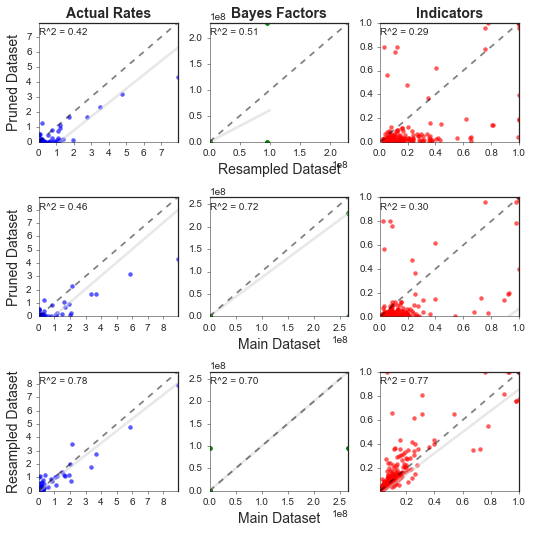

In [34]:
fig, (top, middle, bottom) = plt.subplots(figsize=(7.5,7.5),nrows=3,ncols=3, facecolor='w')


# Compare Actual Rates
top[0].set_title('Actual Rates', size=14, fontweight='bold')    
plot_comparison(compare['main_ar'], compare['resampled_ar'], 
                bottom[0], log=True, color='blue',
                xlabel=' ', ylabel='Resampled Dataset')

plot_comparison(compare['main_ar'], compare['pruned_ar'], 
                middle[0], log=True, color='blue',
                xlabel=' ', ylabel='Pruned Dataset')

plot_comparison(compare['resampled_ar'], compare['pruned_ar'], 
                top[0], log=True, color='blue',
                xlabel=' ', ylabel='Pruned Dataset')


# Compare Bayes Factors
top[1].set_title('Bayes Factors', size=14, fontweight='bold')
plot_comparison(compare['main_bf'], compare['resampled_bf'], 
                bottom[1], log=True, color='green',
                xlabel='Main Dataset', ylabel=' ')

plot_comparison(compare['main_bf'], compare['pruned_bf'], 
                middle[1], log=True, color='green',
                xlabel='Main Dataset', ylabel=' ')

plot_comparison(compare['resampled_bf'], compare['pruned_bf'], 
                top[1], log=True, color='green',
                xlabel='Resampled Dataset', ylabel=' ')

# Compare Indicators
top[2].set_title('Indicators', size=14, fontweight='bold')
plot_comparison(compare['main_indicator'], compare['resampled_indicator'], 
                bottom[2], log=True, color='red',
                xlabel=' ', ylabel=' ')

plot_comparison(compare['main_indicator'], compare['pruned_indicator'], 
                middle[2], log=True, color='red',
                xlabel=' ', ylabel=' ')

plot_comparison(compare['resampled_indicator'], compare['pruned_indicator'], 
                top[2], log=True, color='red',
                xlabel=' ', ylabel=' ')

### Make it pretty
sns.set_style(style='white') 
plt.tight_layout()

### Save our work
# plt.savefig('../png/FigS9.png', bbox_inches='tight', dpi=600)

### Figure S9: Comparison of Discrete Trait Analysis Results

Each datapoint represents on of the 210 possible transmissions between each pair of the 15 hosts present in all three datasets. The black dashed line shows y=x; the linear regression is shown in gray.